In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmaz, sigmay, qeye, ptrace, Qobj
from scipy import integrate
from scipy.linalg import lu_factor, lu_solve
from scipy.interpolate import interp1d
import time
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

### Function: `crank_nicolson_propagator`

**Signature:**
```python
crank_nicolson_propagator(H: Qobj, t: float, steps: int = 100) -> Qobj
```

**Description:**  
Computes the time evolution operator (propagator) for a quantum system governed by the Hamiltonian \( H \), over a time interval \( t \), using the Crank–Nicolson method. This implicit scheme is unconditionally stable and second-order accurate in time.

**Parameters:**
- `H` (`Qobj`): The Hamiltonian of the system (must be Hermitian and square).
- `t` (`float`): Total evolution time.
- `steps` (`int`, default = 100): Number of time steps used to discretize the evolution.

**Returns:**
- `Qobj`: The total unitary propagator \( U(t) \) evolving the system under \( H \) for time \( t \).

**Method:**  
The Crank–Nicolson method approximates the evolution over a time step  
\( \delta t = \frac{t}{\text{steps}} \) as:

$$
U(\delta t) \approx \left(I - \frac{i \delta t}{2} H \right)^{-1} \left(I + \frac{i \delta t}{2} H \right)
$$

The total propagator is:

$$
U(t) = \left[ U(\delta t) \right]^{\text{steps}}
$$

LU decomposition is used to compute the matrix inverse efficiently.






In [9]:
def crank_nicolson_propagator(H: Qobj, t: float, steps: int = 100) -> Qobj:
    """
    Returns the propagator for Hamiltonian H over time t using
    the Crank-Nicolson scheme with the specified number of steps.
    """
    dt = t / steps
    dim = H.shape[0]
    I = np.eye(dim, dtype=complex)
    A = I - 1j * (dt/2) * H.full()
    B = I + 1j * (dt/2) * H.full()
    lu, piv = lu_factor(A)
    U_step = lu_solve((lu, piv), B)
    U_total = np.linalg.matrix_power(U_step, steps)
    return Qobj(U_total, dims=H.dims)

### Function: `spin_chain_ham`

**Signature:**
```python
spin_chain_ham(h, g, J, N)
```

**Description:**  
Constructs the Hamiltonian for the 1D transverse-field Ising model (TFIM) with \( N \) spin-1/2 sites. The model includes nearest-neighbor \( Z \)-\( Z \) interactions, transverse fields in the \( X \)-direction, and longitudinal fields in the \( Z \)-direction.

**Parameters:**
- `h` (`float`): Transverse field strength (along \( x \)-direction).
- `g` (`float`): Longitudinal field strength (along \( z \)-direction).
- `J` (`float`): Coupling strength between neighboring spins.
- `N` (`int`): Number of spins in the 1D chain.

**Returns:**
- `Qobj`: A `qutip.Qobj` representing the Hamiltonian of the spin chain.

**Hamiltonian Form:**  
The total Hamiltonian constructed is:

$$
H = -J \sum_{i=0}^{N-2} \sigma_z^{(i)} \sigma_z^{(i+1)}
\;-\; h \sum_{i=0}^{N-1} \sigma_x^{(i)}
\;-\; g \sum_{i=0}^{N-1} \sigma_z^{(i)}
$$

where:
$$
\sigma_x^{(i)}, \sigma_y^{(i)}, \sigma_z^{(i)} \text{are the Pauli matrices acting on site } i
$$




In [10]:
def spin_chain_ham(h, g, J, N):
    """
    Constructs the transverse-field Ising model Hamiltonian on N spins.
    """
    # Build local Pauli operators on each site.
    sx = [tensor([sigmax() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sy = [tensor([sigmay() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sz = [tensor([sigmaz() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    
    # Nearest-neighbor interactions and on-site fields
    H = sum(-J * sz[i] * sz[i+1] for i in range(N-1)) \
        - sum(h * sx[i] for i in range(N)) \
        - sum(g * sz[i] for i in range(N))
    return H

### Function: `renyi_entropy`

**Signature:**
```python
renyi_entropy(rho, alpha)
```

**Description:**  
Computes the **Rényi entropy** of order $\alpha$ for a given density matrix $\rho$. The Rényi entropy is a generalization of the von Neumann entropy and is useful for quantifying entanglement and uncertainty in quantum states.

**Parameters:**
- `rho` (`Qobj`): A density matrix (`qutip.Qobj`) representing the quantum state. Must be Hermitian and positive semi-definite.
- `alpha` (`float`): The Rényi entropy order parameter \( \alpha > 0 \), \( \alpha \neq 1 \).

**Returns:**
- `float`: The Rényi entropy of order \( \alpha \), computed as:

$$
S_{\alpha}(\rho) = \frac{1}{1 - \alpha} \log \left( \mathrm{Tr} \left[ \rho^{\alpha} \right] \right)
$$





In [11]:
def renyi_entropy(rho, alpha):
    """Computes the Rényi entropy of order alpha from density matrix rho."""
    rho_alpha = rho ** alpha
    return (1/(1-alpha)) * np.log(np.real(rho_alpha.tr()))

In [60]:

N = 10               # Total number of spins
J = 0.65            # Interaction strength
h = 0.9             # Field strength in x-direction
g = 0.4             # Field strength in z-direction
beta = 1.0          # Inverse temperature
alpha = 2           # Order of Rényi entropy

tlist = np.linspace(0, 8.0, 100)   # Time grid for evolution
steps = 100                       # Number of substeps for Crank-Nicolson propagator


### Quench Dynamics in a Transverse-Field Ising Chain

This script simulates the unitary dynamics of a quenched spin system coupled to a thermal bath using a transverse-field Ising model (TFIM). The total system consists of \( N \) qubits, where the first qubit represents the "system" and the remaining \( N-1 \) qubits form the "bath".

**Setup Summary:**

- `H_full`: Full TFIM Hamiltonian on \( N \) spins.
- `H_rest`: Bath-only Hamiltonian on \( N-1 \) spins.
- `H0`: A reference Hamiltonian representing the uncoupled system + bath.
- `H_sys`: System-only Hamiltonian (site 0).
- `thermal_state_rest`: Thermal (Gibbs) state for the bath at inverse temperature \( \beta \).
- `pure_state0`: Pure ground state \( |0\rangle \langle 0| \) for the system.

**Quench and Initial State:**

- The quench is implemented via an operator \( O = \sigma_x \otimes I^{\otimes N-1} \), which perturbs the initial state.
- The full initial state is prepared as:
  $$
  \rho(0) = O \left( |0\rangle\langle0| \otimes \rho_{\text{bath}} \right) O^\dagger
  $$

**Time Evolution:**

- The evolution is done in the **interaction picture**, where the system evolves under:
  $$
  U_{\text{int}}(t) = U_0^\dagger(t) U_{\text{full}}(t)
  $$
- Each evolved state is computed as:
  $$
  \rho(t) = U_{\text{int}}(t) \rho(0) U_{\text{int}}^\dagger(t)
  $$



In [61]:
# Construct the full TFIM Hamiltonian on N spins
H_full = spin_chain_ham(h, g, J, N)

# Construct the Hamiltonian for the rest of the chain (size N-1)
H_rest = spin_chain_ham(h, g, J, N-1)

# Define reference Hamiltonian H0 as H_sys ⊗ I + I ⊗ H_rest
H0 = tensor((-h * sigmax() - g * sigmaz(), *[qeye(2) for _ in range(N-1)])) + tensor(qeye(2), H_rest)

# Define single-site system Hamiltonian
H_sys = -h * sigmax() - g * sigmaz()

# Construct thermal (Gibbs) state for the bath at inverse temperature β
thermal_state_rest = (-beta * H_rest).expm() / (-beta * H_rest).expm().tr()

# Assign the thermal state as the bath state
bath_state_rest = thermal_state_rest

# Define the initial pure state |0⟩⟨0| for the system
pure_state0 = basis(2, 0) * basis(2, 0).dag()

# Define the quench operator O = σₓ ⊗ I^{⊗(N-1)}
O = tensor(sigmax(), *[qeye(2) for _ in range(N-1)])

# Construct the initial state by applying O to the product state
initial_state = O * tensor(pure_state0, bath_state_rest) * O.dag()

# Time evolution of the state in the interaction picture
states = []
for t in tlist:
    # Propagator under reference H0
    U0 = crank_nicolson_propagator(H0, t, steps)

    # Propagator under true full Hamiltonian H
    U_full = crank_nicolson_propagator(H_full, t, steps)

    # Interaction picture evolution operator
    U_int = U0.dag() * U_full

    # Evolve the initial state and store
    evolved_state = U_int * initial_state * U_int.dag()
    states.append(evolved_state)


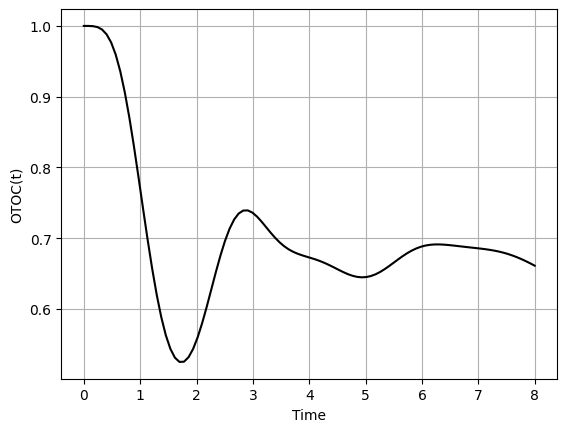

In [62]:

renyi_vals = [renyi_entropy(ptrace(state, [0]), alpha) for state in states]
otoc_plot = np.exp(-np.array(renyi_vals))

np.save(f"otoc_tfim_N_{N}_beta1_long.npy", otoc_plot)
plt.figure()
plt.plot(tlist, otoc_plot, 'k-', label=f'exp(-Rényi {alpha} Entropy)')
plt.xlabel('Time')
plt.ylabel('OTOC(t)')
plt.grid(True)
#plt.savefig(f"N={N}_TFIM_J={J}_h={h}_g={g}_Renyi_entropy_CN.pdf")
plt.show()

### Function: `twopt`

**Signature:**
```python
twopt(H, psi, A, B, t1, t2)
```

**Description:**  
Computes the **two-point correlation function** for operators \( A \) and \( B \) evolved under Hamiltonian $ H $, evaluated on the quantum state $\rho$. The correlation function is computed as:

$$
\langle A(t_1) B(t_2) \rangle = \mathrm{Tr}\left[ A(t_1) B(t_2) \, \rho \right]
$$

where:
- $ A(t_1) = U^\dagger(t_1) A U(t_1) $
- $ B(t_2) = U^\dagger(t_2) B U(t_2) $
- $ U(t) $ is computed using the Crank–Nicolson scheme.

**Parameters:**
- `H` (`Qobj`): Hamiltonian governing the time evolution.
- `psi` (`Qobj`): The initial quantum state (density matrix or pure state).
- `A` (`Qobj`): First observable to evolve to time \( t_1 \).
- `B` (`Qobj`): Second observable to evolve to time \( t_2 \).
- `t1` (`float`): Time at which operator \( A \) is evaluated.
- `t2` (`float`): Time at which operator \( B \) is evaluated.

**Returns:**
- `complex`: The value of the correlation function $ \langle A(t_1) B(t_2) \rangle $.

**Note:**  
This computes the **Heisenberg picture** two-point function without time ordering, i.e., it does **not** enforce $t_1 > t_2 $ or symmetrization.


In [19]:
def twopt(H, psi, A, B, t1, t2):
    """
    Computes the two-point correlation function
         ⟨A(t1) B(t2)⟩ = Tr[A(t1) B(t2) ψ]
    using the Crank-Nicolson propagator.
    """
    U1 = crank_nicolson_propagator(H, t1, steps)
    U2 = crank_nicolson_propagator(H, t2, steps)
    A_t = U1.dag() * A * U1
    B_t = U2.dag() * B * U2
    return (A_t * B_t * psi).tr()

### Function: `state_space_bound_integrand`

**Signature:**
```python
state_space_bound_integrand(y, x, is_thermal)
```

**Description:**  
Computes the integrand for the **state-space (Born) Redfield quantum speed limit bound**, as a function of two time variables \( y \) (outer time) and \( x \) (inner time). This function evaluates how bath correlations and system operator norms evolve over time and contribute to the speed limit integral.

**Parameters:**
- `y` (`float`): Outer time variable of the double integral.
- `x` (`float`): Inner time variable of the double integral.
- `is_thermal` (`bool`): If `True`, use the thermal Gibbs state for the bath; otherwise, compute the time-evolved bath state from the full system.

**Procedure:**
1. **Bath State Selection**:
   - If `is_thermal` is `True`, use the static thermal state.
   - If `False`, evolve the full system to time `y`, and trace out all but the system to obtain the bath state dynamically.

2. **Bath Correlation**:
   - Computes the real part of the two-point function:
     $$
     \mathrm{Re} \left[ \langle B(y) B(x) \rangle \right]
     $$

3. **System Norm Factors**:
   - Evolves \( \sigma_z \) under the system Hamiltonian to times \( y \) and \( x \), and computes the Frobenius norm of each evolved operator.

4. **Returns**:
   - The integrand value:
     $$
     4 J^2 \cdot \mathrm{corr}(y, x) \cdot \| \sigma_z(y) \|_{sp} \cdot \| \sigma_z(x) \|_{sp}
     $$

**Returns:**
- `float`: Real-valued contribution to the double integral over \( x, y \) in the Redfield bound expression.


In [26]:

def state_space_bound_integrand(y, x, is_thermal):
    """
    Integrand for the state-space Redfield bound.
    y corresponds to the outer time variable and x to the inner one.
    """
    # Choose the bath state based on the flag
    if is_thermal:
        bath_state = bath_state_rest
    else:
        U0 = crank_nicolson_propagator(H0, y, steps)
        U_full = crank_nicolson_propagator(H_full, y, steps)
        U_int = U0.dag() * U_full
        evolved = U_int * initial_state * U_int.dag()
        bath_state = ptrace(evolved, list(range(1, N)))
    
    # Two-point correlation function for the bath operator.
    corr = np.real(twopt(H_rest, bath_state, bath_op, bath_op, y, x))
    
    # Evolve the system operator for time y and x.
    U_sys_y = crank_nicolson_propagator(H_sys, y, steps)
    U_sys_x = crank_nicolson_propagator(H_sys, x, steps)
    sigz_y = U_sys_y.dag() * sigmaz() * U_sys_y
    sigz_x = U_sys_x.dag() * sigmaz() * U_sys_x
    norm_y = np.linalg.norm(sigz_y.full(), ord=2)
    norm_x = np.linalg.norm(sigz_x.full(), ord=2)
    
    return 4 * (J**2) * corr * norm_y * norm_x


### Functions: `liouv_superop` and `liouv_spec_integrand`

---

#### `liouv_superop(t1, t2, is_thermal)`

Constructs the **Liouvillian superoperator** $ \mathcal{L}(t_1, t_2) $ for a system coupled to a bath, based on operator evolution and bath two-point correlation functions.

**Mathematical Form:**
The superoperator is given by:
$$
\mathcal{L}(t_1, t_2) = -J^2 \left[ C(t_1, t_2) \left( \sigma_z(t_1) \sigma_z(t_2) \otimes I + \sigma_z(t_2) \otimes \sigma_z(t_1) \right)
+ C^*(t_1, t_2) \left( I \otimes \sigma_z(t_2)\sigma_z(t_1) + \sigma_z(t_1) \otimes \sigma_z(t_2) \right) \right]
$$

Returns the **anti-Hermitian part** of this operator:
$$
\mathcal{L}_{\text{eff}} = \mathcal{L} - \mathcal{L}^\dagger
$$

**Arguments:**
- `t1`, `t2`: Time points for operator evolution.
- `is_thermal`: Whether to use the static thermal bath state (`True`) or dynamically evolved bath state (`False`).

---

#### `liouv_space_bound_integrand(y, x, is_thermal)`

Computes the **spectral-norm-based integrand** for the Liouvillian quantum speed limit bound:
$$
\text{Integrand}(y, x) = \| \mathcal{L}(y, x) \|_{sp}
$$

This is used to estimate how non-unitary generator contributions bound the evolution speed of an open quantum system.

**Returns:**
- A scalar value representing the spectral norm of $ \mathcal{L}(y, x) $.



In [27]:
def liouv_superop(t1, t2, is_thermal):
    """
    Constructs a Liouvillian superoperator based on the time-evolved
    operators and the bath two-point correlation.
    """
    if is_thermal:
        bath_state = bath_state_rest
    else:
        U0 = crank_nicolson_propagator(H0, t1, steps)
        U_full = crank_nicolson_propagator(H_full, t1, steps)
        U_int = U0.dag() * U_full
        evolved = U_int * initial_state * U_int.dag()
        bath_state = ptrace(evolved, list(range(1, N)))
    
    U_sys_t1 = crank_nicolson_propagator(H_sys, t1, steps)
    U_sys_t2 = crank_nicolson_propagator(H_sys, t2, steps)
    sigz_t1 = U_sys_t1.dag() * sigmaz() * U_sys_t1
    sigz_t2 = U_sys_t2.dag() * sigmaz() * U_sys_t2
    bath_corr = twopt(H_rest, bath_state, bath_op, bath_op, t1, t2)
    
    # Construct two parts of the superoperator
    superop1 = -(J**2) * bath_corr * (tensor(sigz_t1 * sigz_t2, qeye(2)) + tensor(sigz_t2, sigz_t1))
    superop2 = -(J**2) * np.conj(bath_corr) * (tensor(qeye(2), sigz_t2 * sigz_t1) + tensor(sigz_t1, sigz_t2))
    L = superop1 + superop2
    return (L - L.dag()).full()


def liouv_space_bound_integrand(y, x, is_thermal):
    """
    Integrand for the Liouvillian spectral bound.
    Returns the 2-norm of the liouvillian superoperator at (y, x).
    """
    return np.linalg.norm(liouv_superop(y, x, is_thermal), ord=2)


### Functions: `precompute_inner_integral_function` and `compute_incremental_double_integral_precomp`

---

#### `precompute_inner_integral_function(f, is_thermal, y_max, num_points=200)`

This function precomputes the **inner integral** of a two-variable function:
$$
g(y) = \int_0^y f(y, x, \text{is_thermal}) \, dx
$$

It:
- Evaluates this inner integral on a uniform grid over $ y \in [0, y_{\text{max}}] $,
- Uses `scipy.integrate.quad` for accurate quadrature,
- Returns a smooth **cubic interpolation function** $ g(y) $ for reuse.

**Arguments:**
- `f`: Callable with signature `f(y, x, is_thermal)` (typically a kernel-like integrand).
- `is_thermal`: Flag for whether to use thermal bath or evolved bath state.
- `y_max`: Maximum value of \( y \) in the domain.
- `num_points`: Number of discrete \( y \)-grid points.

---

#### `compute_incremental_double_integral_precomp(g_interp, tlist)`

Computes the **outer integral** incrementally using the precomputed interpolant \( g(y) \):
$$
I(t) = \int_0^t g(y) \, dy
$$

This is done incrementally across the `tlist` time grid using `quad` over segments.

**Returns:**
- List of integral values $ I(t_i) $ for each $ t_i \in \text{tlist} $.


In [28]:

def precompute_inner_integral_function(f, is_thermal, y_max, num_points=200):
    """
    Precomputes the inner integral
         g(y) = ∫[0,y] f(y, x, is_thermal) dx
    on a grid of y values spanning [0, y_max] and returns an interpolating
    function for g(y).
    """
    y_vals = np.linspace(0, y_max, num_points)
    inner_vals = np.zeros_like(y_vals)
    for idx, y in enumerate(y_vals):
        # Compute the inner integral using quad
        inner_vals[idx], err = integrate.quad(lambda x: f(y, x, is_thermal), 0, y)
    # Create an interpolation function from the precomputed values.
    g_interp = interp1d(y_vals, inner_vals, kind='cubic', fill_value="extrapolate")
    return g_interp

def compute_incremental_double_integral_precomp(g_interp, tlist):
    """
    Computes the double integral
         I(t) = ∫[0,t] g(y) dy,
    where g(y) is provided as an interpolating function (precomputed inner integral).
    The outer integral is computed incrementally over the time grid.
    """
    cumulative = 0.0
    results = [0.0]  # I(0) = 0
    for i in range(1, len(tlist)):
        t_prev = tlist[i-1]
        t_curr = tlist[i]
        increment, err = integrate.quad(g_interp, t_prev, t_curr)
        cumulative += increment
        results.append(cumulative)
    return results


In [29]:
# For the bath (N-1 spins), we act on the first bath spin.
bath_op = tensor(sigmaz(), *[qeye(2) for _ in range((N-1)-1)])

In [30]:

y_max = tlist[-1]

# Precompute the inner integral for the Redfield integrand:

start_precomp = time.time()
g_state_space_bound_interp = precompute_inner_integral_function(state_space_bound_integrand, True, y_max, num_points=200)
end_precomp = time.time()

# Compute the state-space (Born) Redfield bound incrementally using the precomputed g(y):
start_precomp_redfield = time.time()
state_space_bound_precomp = compute_incremental_double_integral_precomp(g_state_space_bound_interp, tlist)
end_precomp_redfield = time.time()

g_state_space_bound_nb_interp = precompute_inner_integral_function(state_space_bound_integrand, False, y_max, num_points=200)
state_space_bound_nb_precomp = compute_incremental_double_integral_precomp(g_state_space_bound_nb_interp, tlist)

# Precompute the inner integral for the Liouvillian spectral integrand:
g_liouv_space_bound_interp = precompute_inner_integral_function(liouv_space_bound_integrand, True, y_max, num_points=200)

# Compute the Liouvillian spectral bound incrementally using the precomputed g(y):
start_precomp_liouv = time.time()
liouv_space_bound_precomp = compute_incremental_double_integral_precomp(g_liouv_space_bound_interp, tlist)
end_precomp_liouv = time.time()

g_liouv_space_bound_nb_interp = precompute_inner_integral_function(liouv_space_bound_integrand, False, y_max, num_points=200)
liouv_space_bound_nb_precomp = compute_incremental_double_integral_precomp(g_liouv_space_bound_nb_interp, tlist)


precomp_time = end_precomp - start_precomp
precomp_time_redfield = end_precomp_redfield - start_precomp_redfield
precomp_time_liouv = end_precomp_liouv - start_precomp_liouv

print("Precomputed Integration Times:")
print(f"Precomputation time:{precomp_time:.4f}seconds")
print(f"Redfield bound (precomp): {precomp_time_redfield:.4f} seconds")
print(f"Liouvillian spectral bound (precomp): {precomp_time_liouv:.4f} seconds")

Precomputed Integration Times:
Precomputation time:1.8947seconds
Redfield bound (precomp): 0.0028 seconds
Liouvillian spectral bound (precomp): 0.0027 seconds


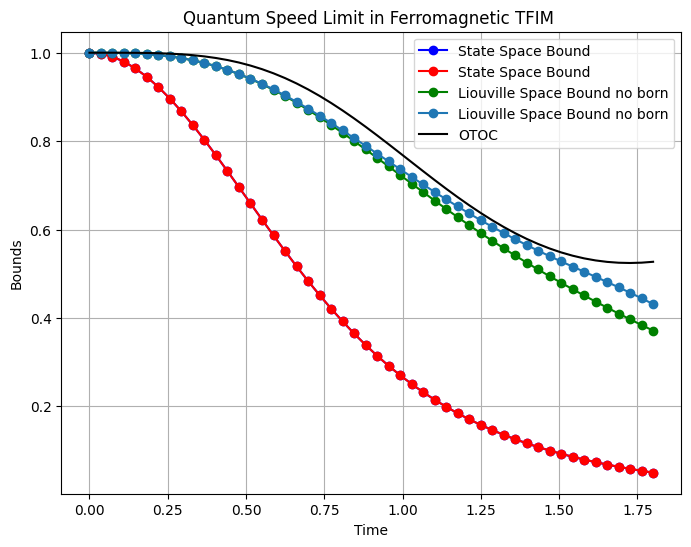

In [36]:

# Plotting the Results

exp_state_space_bound_precomp = np.exp(-2*np.array(state_space_bound_precomp))
exp_state_space_bound_nb_precomp = np.exp(-2*np.array(state_space_bound_nb_precomp))

exp_liouv_space_bound_precomp = np.exp(-np.array(liouv_space_bound_precomp))
exp_liouv_space_bound_nb_precomp = np.exp(-np.array(liouv_space_bound_nb_precomp))

plt.figure(figsize=(8,6))
plt.plot(tlist, exp_state_space_bound_precomp, 'b-o', label='State Space Bound')
plt.plot(tlist, exp_state_space_bound_nb_precomp, 'r-o', label='State Space Bound ')
plt.plot(tlist, exp_liouv_space_bound_precomp, 'g-o', label='Liouville Space Bound no born')
plt.plot(tlist, exp_liouv_space_bound_nb_precomp, '-o', label='Liouville Space Bound no born')
plt.plot(tlist, otoc_plot, 'k-', label='OTOC')
plt.xlabel('Time')
plt.ylabel('Bounds')
plt.title('Quantum Speed Limit in Ferromagnetic TFIM ')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig("afm qsl_tfim_plot N=8.pdf")

#np.save("tlist.npy", tlist)
#np.save("otoc_tfim_N6_beta1.npy", renyi_plot)
#np.save("state_bound_tfim_N6_beta1.npy", exp_redfield_bound_precomp)
#np.save("liov_bound_tfim_N6_beta1.npy", exp_redfield_spec_bound_precomp)